The first thing to say about REBOUND in general, is that it doesn't use input files.  Instead you should think about it as a toolbox, a high-level language for doing N-body simulations.  The second thing is that REBOUND is written in C so that it's as fast as possible, but Hanno and I have spent a lot of time over the last year developing a Python wrapper for it.  This allows you to interface with Python's huge number of actively developed libraries and makes many new things possible, as I hope to show you in this iPython notebook, where we'll try to use REBOUNDx to migrate Jupiters into resonance.

If you haven't seen iPython notebooks before, they allow you to interactively execute Python code, similar to what you might be used to from things like IDL, Mathematica and Matlab.  We always begin by importing the libraries we need:

In [6]:
import numpy as np
import rebound

sim = rebound.Simulation()
sim.G = 4*np.pi**2
sim.add(m=1.)
sim.add(m=1.e-3, a=1.)
sim.add(m=1.e-3, P=2.2)
sim.move_to_com()

We always start by making a simulation.  You can use whatever units you like.  Let's use AUs, years and solar masses, so G should be 4pi^2.  Now we add particles to the simulation.  This add function has a lot of options.  Let's add a 1 solar mass star.  Anything I don't pass gets set to 0, so it's initialized at rest at the origin.  Let's add a Jupiter at 1 AU.  I could initialize it with Cartesian positions and velocities, but I can also pass orbital elements.  If I add a name here, it will use the telnet to query JPL HORIZONS for the object's current position (pretty cool!) but let's just add another Jupiter a bit outside the 2:1 resonance.  And let's work in the center of mass frame.  So we've set up our simulation.  Let's quickly make sure it looks the way we expect:

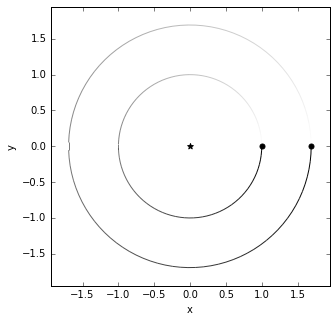

In [7]:
%matplotlib inline
fig = rebound.OrbitPlot(sim, trails=True)

Now let's use REBOUNDx to add migration.  We import the library, and attach an Extras instance to our simulation.  This Extras class is the main object in REBOUNDx that allows you to add all the different effects to your simulation.  

Now we add the effect we're interested in.  Migration is inside modify_orbits_forces, but we could also add_gr(), add_radiation_forces().  I'll show you what's available later.  

Different effects allow you to add different properties to your particles.  In this case, we can add an exponential timescale to the semimajor axis of any particle.  Let's make the outermost one migrate inward.  We know that we have to make this timescale longer than the libration timescale inside the resonance, but I don't know that number off the top my head, so let's try an e-folding timescale of 1000 years (negative gives us damping).

In [8]:
import reboundx
rebx = reboundx.Extras(sim)
rebx.add_modify_orbits_forces()

ps = sim.particles
ps[2].tau_a = -500

Now we do the integration.  Let's make a list of times where we want outputs, from 0 to one e-folding timescale, and let's get 1000 of them.  Now we step through each of those 1000 times, tell our simulation to integrate up until that time, and then let's store the period ratio between the two planets at each output.  

In [9]:
times = np.linspace(0, -ps[2].tau_a, 1000)
Pratio = np.zeros(1000)
for i, time in enumerate(times):
    sim.integrate(time)
    Pratio[i] = ps[2].P/ps[1].P

Since we're working in Python, it's trivial to plot it:

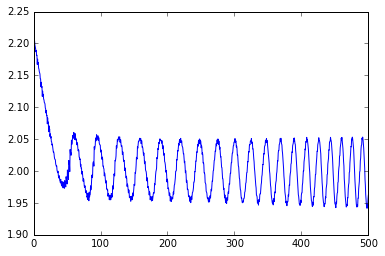

In [10]:
import matplotlib.pyplot as plt
plt.plot(times, Pratio)

Great! So the outer planet migrates inward, and then the pair gets caught into resonance at a period ratio of 2.  Could we have migrated faster?  That's the great part about this being interactive, I can just go back up and change things.

Still captures.  OK, a little cleaner is to turn everything we've done above into a function that takes a damping timescale as a parameter.  You have this in your notebook if you're following on binder.

In [7]:
%%px --local 
import rebound
import numpy as np
import reboundx
def run(tau_a):
    sim = rebound.Simulation()
    sim.G = 4*np.pi**2
    sim.add(m=1.)
    sim.add(m=1.e-3, a=1.)
    sim.add(m=1.e-3, P=2.2)
    sim.move_to_com()
    rebx = reboundx.Extras(sim)
    params = rebx.add_modify_orbits_forces()

    ps = sim.particles
    ps[2].tau_a = tau_a
    times = np.linspace(0, -ps[2].tau_a, 1000)
    Pratio = np.zeros(1000)
    for i, time in enumerate(times):
        sim.integrate(time)
        Pratio[i] = ps[2].P/ps[1].P
    return Pratio[-1]

Now we can just call the function with the same timescale, and we get the same plot.  So how fast do we have to go to not capture?  Let's try 100 years.

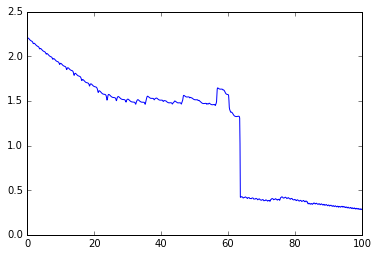

In [8]:
times, Pratio = run(-100)
plt.plot(times, Pratio)

OK, so whether you capture transitions somewhere between 100 and 500 years.  As a final demonstration, let's do something more systematic by scaling this up a bit.  This is an embarrassingly simple module I wrote using the ipyparallel library to distribute my work to machines at CITA.  Here I'm starting 30 engines on one of our workstations.

In [9]:
from cluster import cluster as cl
rc = cl.start_cluster('lobster', 30)

ImportError: No module named 'cluster'

Here we can see all 30 are up and running:

In [ ]:
rc.ids

Let's change our function so instead of all this information it just returns the period ratio at the end of the integration.  Now the only thing I have to do is add this iPython magic %%px --local so that all the engines have our run function.  So let's try a bunch of damping timescales between -100 and -1000.  Let's try 100 of them.  I now just have to run one command that maps our function to all the engines, distributing all the tau_as we want to use.  Let's plot them.

In [ ]:
tau_as = np.linspace(-100,-1000, 100)
pratios = rc[:].map_sync(run, tau_as)

In [ ]:
plt.plot(tau_as, pratios, '.')

In [ ]:
cl.shutdown_cluster('lobster', rc)